# 7. Survival Analysis with Patient-Level Embeddings

This notebook performs survival analysis using the patient-level embeddings generated in notebook 04.
We'll analyze:
1. Individual modality performance for survival prediction
2. Multimodal fusion performance comparison
3. Risk stratification using different survival models
4. Cancer-specific survival patterns

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Survival analysis imports
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

## 7.1 Load Patient-Level Embeddings

In [2]:
# Load cached patient-level embeddings
cache_dir = Path('embedding_cache')

# Load individual modality embeddings
modality_embeddings = {}
modalities = ['clinical', 'pathology', 'wsi', 'molecular', 'radiology']

for modality in modalities:
    # Check for embeddings and metadata files
    embeddings_file = cache_dir / f'{modality}_embeddings.npy'
    metadata_file = cache_dir / f'{modality}_metadata.pkl'
    
    if embeddings_file.exists() and metadata_file.exists():
        # Load embeddings
        embeddings = np.load(embeddings_file)
        
        # Load metadata
        with open(metadata_file, 'rb') as f:
            metadata = pickle.load(f)
        
        # For WSI and radiology, check if these are patient-level or need aggregation
        if modality in ['wsi', 'radiology']:
            # Check if we have sample-level data that needs aggregation
            sample_level_file = cache_dir / f'{modality}_embeddings_sample_level.npy'
            if sample_level_file.exists():
                print(f"Note: {modality} has sample-level data, using patient-aggregated version")
        
        modality_embeddings[modality] = {
            'embeddings': embeddings,
            'metadata': metadata
        }
        print(f"Loaded {modality}: {embeddings.shape[0]} samples, {embeddings.shape[1]} dimensions")
        
        # Check if this is patient-level data
        if 'patient_id' in metadata.columns:
            unique_patients = metadata['patient_id'].nunique()
            print(f"  Unique patients: {unique_patients}")
    else:
        print(f"Warning: {modality} embeddings not found")

# Load multimodal embeddings if available
multimodal_file = cache_dir / 'multimodal_results.pkl'
if multimodal_file.exists():
    with open(multimodal_file, 'rb') as f:
        multimodal_data = pickle.load(f)
        
    # Extract different fusion methods
    # The multimodal data is stored as arrays directly, not as dicts with 'embeddings' key
    fusion_methods = ['concat', 'mean_pool', 'kronecker']
    shared_metadata = multimodal_data.get('metadata', None)
    
    for method in fusion_methods:
        if method in multimodal_data and isinstance(multimodal_data[method], np.ndarray):
            modality_embeddings[method] = {
                'embeddings': multimodal_data[method],
                'metadata': shared_metadata if shared_metadata is not None else pd.DataFrame()
            }
            emb = multimodal_data[method]
            print(f"Loaded {method}: {emb.shape[0]} patients, {emb.shape[1]} dimensions")

Loaded clinical: 10771 samples, 1024 dimensions
Loaded pathology: 10857 samples, 1024 dimensions
Note: wsi has sample-level data, using patient-aggregated version
Loaded wsi: 8060 samples, 1024 dimensions
  Unique patients: 8060
Loaded molecular: 13804 samples, 48 dimensions
Note: radiology has sample-level data, using patient-aggregated version
Loaded radiology: 1149 samples, 1000 dimensions
  Unique patients: 1149
Loaded concat: 3000 patients, 4120 dimensions
Loaded mean_pool: 3000 patients, 1024 dimensions
Loaded kronecker: 3000 patients, 100 dimensions


## 7.2 Load Survival Data

In [3]:
# Load actual TCGA survival data from the clinical metadata
print("Loading real TCGA survival data from clinical metadata...")

# The clinical metadata already contains survival information
if 'clinical' in modality_embeddings:
    clinical_metadata = modality_embeddings['clinical']['metadata']
    print(f"Clinical metadata shape: {clinical_metadata.shape}")
    print(f"Available columns: {clinical_metadata.columns.tolist()[:20]}...")
    
    # Extract survival information from the metadata
    # days_to_death: days from diagnosis to death (for deceased patients)
    # days_to_last_follow_up: days from diagnosis to last follow-up (for alive patients)
    # vital_status: Alive or Dead
    
    # Create survival DataFrame
    survival_data = []
    
    for idx, row in clinical_metadata.iterrows():
        patient_id = row['case_submitter_id']
        cancer_type = row['project_id']
        vital_status = row['vital_status']
        
        # Determine survival time and event
        if vital_status == 'Dead':
            # Patient died - use days_to_death
            survival_time = row['days_to_death']
            event = True
        else:
            # Patient alive at last follow-up - use days_to_last_follow_up
            survival_time = row['days_to_last_follow_up']
            event = False
        
        # Convert survival time to numeric
        try:
            # Handle various possible formats
            if pd.notna(survival_time):
                survival_time_numeric = float(survival_time)
                
                # Skip patients with invalid survival data
                if survival_time_numeric > 0:
                    survival_data.append({
                        'patient_id': patient_id,
                        'cancer_type': cancer_type,
                        'survival_time': survival_time_numeric,
                        'event': event,
                        'vital_status': vital_status,
                        'age_at_diagnosis': row.get('age_at_diagnosis', np.nan),
                        'gender': row.get('gender', 'Unknown'),
                        'stage': row.get('ajcc_pathologic_stage', 'Unknown')
                    })
        except (ValueError, TypeError):
            # Skip patients with non-numeric survival times
            continue
    
    survival_df = pd.DataFrame(survival_data)
    
    print(f"\nCreated survival data for {len(survival_df)} patients with complete survival information")
    print(f"Total patients in metadata: {len(clinical_metadata)}")
    print(f"Patients with missing/invalid survival data: {len(clinical_metadata) - len(survival_df)}")
    
    if len(survival_df) > 0:
        print(f"Overall event rate (deaths): {survival_df['event'].mean():.2%}")
        print(f"Median follow-up time: {survival_df['survival_time'].median():.0f} days")
        
        # Show survival statistics by cancer type
        print(f"\nSurvival statistics by cancer type:")
        cancer_stats = survival_df.groupby('cancer_type').agg({
            'survival_time': ['count', 'mean', 'median'],
            'event': ['sum', 'mean']
        }).round(2)
        cancer_stats.columns = ['N_patients', 'Mean_survival', 'Median_survival', 'N_deaths', 'Death_rate']
        cancer_stats = cancer_stats.sort_values('N_patients', ascending=False)
        print(cancer_stats.head(10))
        
        # Show vital status distribution
        print(f"\nVital status distribution:")
        print(survival_df['vital_status'].value_counts())
        
        # Check for any data quality issues
        print(f"\nData quality check:")
        print(f"Patients with survival time <= 0: {(survival_df['survival_time'] <= 0).sum()}")
        print(f"Patients with survival time > 10 years: {(survival_df['survival_time'] > 3650).sum()}")
    else:
        print("\nWarning: No valid survival data found. Please check the data format.")
        
else:
    print("Error: Clinical embeddings not found. Please run notebook 04 first to generate embeddings.")

Loading real TCGA survival data from clinical metadata...
Clinical metadata shape: (10771, 114)
Available columns: ['project_id', 'case_id', 'case_submitter_id', 'selected_normal_wgs', 'source_center', 'state', 'a260_a280_ratio', 'normal_tumor_genotype_snp_match', 'ribosomal_rna_28s_16s_ratio', 'rna_integrity_number', 'age_at_index', 'days_to_birth', 'days_to_death', 'ethnicity', 'gender', 'race', 'vital_status', 'year_of_birth', 'year_of_death', 'age_at_diagnosis']...

Created survival data for 10771 patients with complete survival information
Total patients in metadata: 10771
Patients with missing/invalid survival data: 0
Overall event rate (deaths): 32.12%
Median follow-up time: 730 days

Survival statistics by cancer type:
             N_patients  Mean_survival  Median_survival  N_deaths  Death_rate
cancer_type                                                                  
TCGA-BRCA          1075        1257.26            860.0       149        0.14
TCGA-GBM            590      

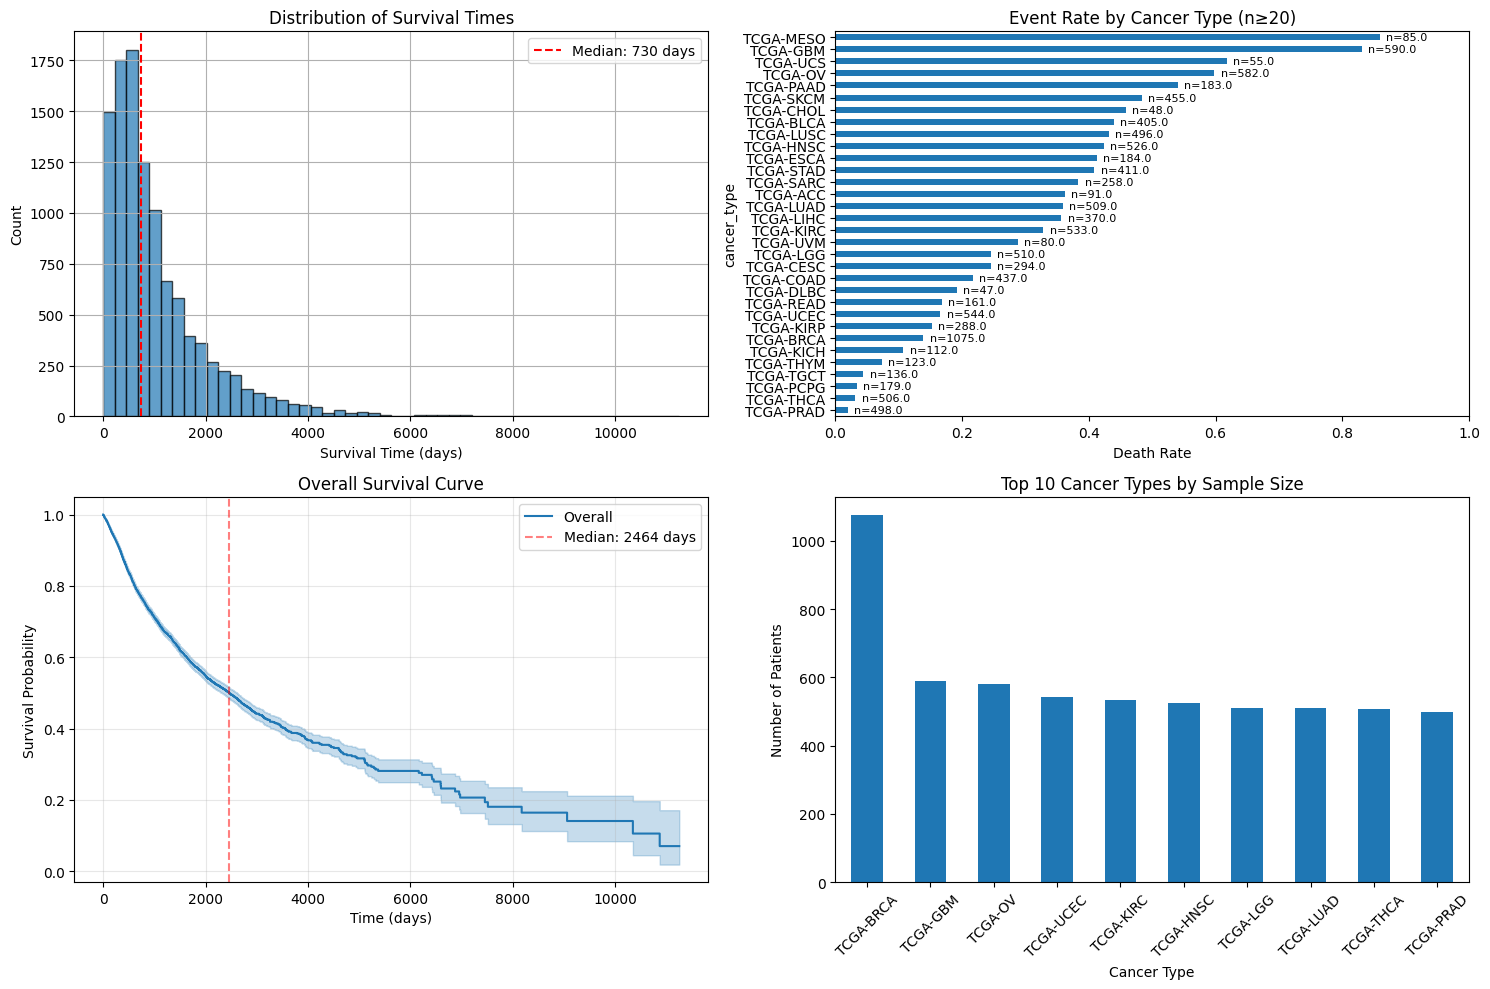


Survival Data Statistics:
Total patients: 10771
Deaths: 3460 (32.1%)
Censored: 7311 (67.9%)

Survival time statistics (days):
  Mean: 1056
  Median: 730
  Min: 1
  Max: 11252
  1-year survival: 77.9%
  5-year survival: 16.6%


In [4]:
# Visualize survival data characteristics
if 'survival_df' in locals() and len(survival_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Survival time distribution
    ax = axes[0, 0]
    survival_df['survival_time'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Survival Time (days)')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Survival Times')
    ax.axvline(survival_df['survival_time'].median(), color='red', linestyle='--', 
               label=f'Median: {survival_df["survival_time"].median():.0f} days')
    ax.legend()
    
    # 2. Event rate by cancer type
    ax = axes[0, 1]
    event_by_cancer = survival_df.groupby('cancer_type')['event'].agg(['mean', 'count'])
    event_by_cancer = event_by_cancer[event_by_cancer['count'] >= 20].sort_values('mean')
    event_by_cancer['mean'].plot(kind='barh', ax=ax)
    ax.set_xlabel('Death Rate')
    ax.set_title('Event Rate by Cancer Type (n≥20)')
    ax.set_xlim(0, 1)
    
    # Add sample counts
    for i, (cancer, row) in enumerate(event_by_cancer.iterrows()):
        ax.text(row['mean'] + 0.01, i, f"n={row['count']}", va='center', fontsize=8)
    
    # 3. Kaplan-Meier curve for overall survival
    ax = axes[1, 0]
    kmf = KaplanMeierFitter()
    kmf.fit(survival_df['survival_time'], survival_df['event'], label='Overall')
    kmf.plot_survival_function(ax=ax)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Survival Probability')
    ax.set_title('Overall Survival Curve')
    ax.grid(True, alpha=0.3)
    
    # Add median survival time
    median_surv = kmf.median_survival_time_
    if not np.isnan(median_surv):
        ax.axvline(median_surv, color='red', linestyle='--', alpha=0.5, 
                   label=f'Median: {median_surv:.0f} days')
        ax.legend()
    
    # 4. Top cancer types by sample size
    ax = axes[1, 1]
    top_cancers = survival_df['cancer_type'].value_counts().head(10)
    top_cancers.plot(kind='bar', ax=ax)
    ax.set_xlabel('Cancer Type')
    ax.set_ylabel('Number of Patients')
    ax.set_title('Top 10 Cancer Types by Sample Size')
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print survival statistics
    print("\nSurvival Data Statistics:")
    print(f"Total patients: {len(survival_df)}")
    print(f"Deaths: {survival_df['event'].sum()} ({survival_df['event'].mean():.1%})")
    print(f"Censored: {(~survival_df['event']).sum()} ({(~survival_df['event']).mean():.1%})")
    print(f"\nSurvival time statistics (days):")
    print(f"  Mean: {survival_df['survival_time'].mean():.0f}")
    print(f"  Median: {survival_df['survival_time'].median():.0f}")
    print(f"  Min: {survival_df['survival_time'].min():.0f}")
    print(f"  Max: {survival_df['survival_time'].max():.0f}")
    print(f"  1-year survival: {(survival_df['survival_time'] > 365).mean():.1%}")
    print(f"  5-year survival: {(survival_df['survival_time'] > 1825).mean():.1%}")

## 7.3 Define Survival Models

In [5]:
# Define DeepSurv model
class DeepSurv(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128], dropout=0.3):
        super(DeepSurv, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # Output layer for hazard ratio
        layers.append(nn.Linear(prev_dim, 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Helper functions for model training
def prepare_survival_data(embeddings, survival_df, test_size=0.2):
    """
    Prepare data for survival analysis with real TCGA data
    """
    # Get embeddings and metadata
    X = embeddings['embeddings']
    metadata = embeddings['metadata'].copy()
    
    # For clinical data, we can directly use case_submitter_id
    # For other modalities, we need to check what patient identifier is available
    if 'case_submitter_id' in metadata.columns:
        metadata['patient_id'] = metadata['case_submitter_id']
    elif 'PatientID' in metadata.columns:
        metadata['patient_id'] = metadata['PatientID']
    elif 'patient_id' not in metadata.columns:
        # If no patient ID column, create one from index
        print(f"Warning: No patient ID column found in metadata. Using index.")
        metadata['patient_id'] = metadata.index.astype(str)
    
    # Merge with survival data
    merged_df = metadata.merge(survival_df[['patient_id', 'survival_time', 'event', 'cancer_type']], 
                              on='patient_id', how='inner', suffixes=('', '_survival'))
    
    if len(merged_df) == 0:
        print(f"Warning: No matching patients found between embeddings and survival data")
        print(f"Embedding patient IDs sample: {metadata['patient_id'].head().tolist()}")
        print(f"Survival patient IDs sample: {survival_df['patient_id'].head().tolist()}")
        # Try to find common patients
        common_patients = set(metadata['patient_id']) & set(survival_df['patient_id'])
        print(f"Common patients found: {len(common_patients)}")
        if len(common_patients) == 0:
            raise ValueError("No matching patients found between embeddings and survival data")
    
    print(f"Matched {len(merged_df)} patients with both embeddings and survival data")
    
    # Get aligned embeddings based on original metadata indices
    # Since we're merging, we need to track which rows from the original data we're using
    original_indices = merged_df.index.values
    
    # Handle case where indices might be out of bounds
    valid_indices = [idx for idx in original_indices if idx < len(X)]
    if len(valid_indices) < len(original_indices):
        print(f"Warning: Some indices out of bounds. Using {len(valid_indices)} out of {len(original_indices)} samples")
        merged_df = merged_df.loc[valid_indices]
    
    X_aligned = X[valid_indices]
    
    # Prepare survival data for scikit-survival
    y = np.array([(bool(e), t) for e, t in zip(merged_df['event'], merged_df['survival_time'])],
                 dtype=[('event', '?'), ('time', '<f8')])
    
    # Get cancer type for stratification
    cancer_type_col = 'cancer_type_survival' if 'cancer_type_survival' in merged_df.columns else 'cancer_type'
    
    # Only stratify if we have enough samples per cancer type
    stratify = None
    if cancer_type_col in merged_df.columns:
        cancer_counts = merged_df[cancer_type_col].value_counts()
        # Need at least 2 samples per class for stratification
        valid_cancers = cancer_counts[cancer_counts >= 2].index
        if len(valid_cancers) > 1:
            # Filter to only include cancers with enough samples
            mask = merged_df[cancer_type_col].isin(valid_cancers)
            if mask.sum() > 0.8 * len(merged_df):  # If we're not losing too many samples
                stratify = merged_df[cancer_type_col]
    
    # Split data
    try:
        if stratify is not None:
            X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
                X_aligned, y, np.arange(len(y)), test_size=test_size, random_state=42, stratify=stratify
            )
        else:
            X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
                X_aligned, y, np.arange(len(y)), test_size=test_size, random_state=42
            )
    except ValueError as e:
        print(f"Stratification failed: {e}. Falling back to random split.")
        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
            X_aligned, y, np.arange(len(y)), test_size=test_size, random_state=42
        )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Return data and metadata
    return X_train_scaled, X_test_scaled, y_train, y_test, merged_df.iloc[idx_train], merged_df.iloc[idx_test], scaler

In [6]:
def nested_cv_survival(embeddings, survival_df, modality_name, model_type='cox', 
                      n_outer_folds=5, n_inner_folds=3, random_state=42):
    """
    Perform nested cross-validation for survival analysis
    
    Parameters:
    -----------
    embeddings : dict
        Dictionary with 'embeddings' and 'metadata' keys
    survival_df : pd.DataFrame
        Survival data with patient_id, survival_time, event columns
    modality_name : str
        Name of the modality for tracking
    model_type : str
        Type of model: 'cox', 'rsf', or 'deepsurv'
    n_outer_folds : int
        Number of outer CV folds
    n_inner_folds : int
        Number of inner CV folds for hyperparameter tuning
    
    Returns:
    --------
    dict : Results including C-indices, models, and metadata
    """
    print(f"\n{'='*60}")
    print(f"Nested CV for {modality_name} using {model_type}")
    print(f"{'='*60}")
    
    # Prepare data
    try:
        X_full, X_test_full, y_full, y_test_full, train_df, test_df, scaler_full = prepare_survival_data(
            embeddings, survival_df, test_size=0.0  # Use all data for CV
        )
        # Combine train and test for full dataset
        X_all = np.vstack([X_full, X_test_full]) if len(X_test_full) > 0 else X_full
        y_all = np.concatenate([y_full, y_test_full]) if len(y_test_full) > 0 else y_full
        metadata_all = pd.concat([train_df, test_df]) if len(test_df) > 0 else train_df
    except:
        # If that fails, prepare all data together
        X = embeddings['embeddings']
        metadata = embeddings['metadata'].copy()
        
        if 'case_submitter_id' in metadata.columns:
            metadata['patient_id'] = metadata['case_submitter_id']
        elif 'PatientID' in metadata.columns:
            metadata['patient_id'] = metadata['PatientID']
        
        # Merge with survival data
        merged_df = metadata.merge(
            survival_df[['patient_id', 'survival_time', 'event', 'cancer_type']], 
            on='patient_id', how='inner'
        )
        
        # Get aligned data
        X_all = X[merged_df.index.values]
        y_all = np.array([(bool(e), t) for e, t in zip(merged_df['event'], merged_df['survival_time'])],
                        dtype=[('event', '?'), ('time', '<f8')])
        metadata_all = merged_df
    
    print(f"Total samples: {len(X_all)}")
    print(f"Event rate: {y_all['event'].mean():.2%}")
    
    # Results storage
    cv_results = {
        'modality': modality_name,
        'model_type': model_type,
        'outer_fold_results': [],
        'best_params': [],
        'train_c_indices': [],
        'val_c_indices': [],
        'test_c_indices': [],
        'models': [],
        'scalers': []
    }
    
    # Create stratification variable based on events and cancer types
    stratify_var = y_all['event'].astype(int)
    if 'cancer_type' in metadata_all.columns:
        # Create combined stratification variable
        cancer_types = metadata_all['cancer_type'].fillna('Unknown')
        unique_cancers = cancer_types.unique()
        cancer_to_int = {c: i for i, c in enumerate(unique_cancers)}
        cancer_int = cancer_types.map(cancer_to_int).values
        # Combine event and cancer type for stratification
        stratify_var = stratify_var * len(unique_cancers) + cancer_int
    
    # Outer CV
    outer_cv = StratifiedKFold(n_splits=n_outer_folds, shuffle=True, random_state=random_state)
    
    for fold_idx, (train_val_idx, test_idx) in enumerate(outer_cv.split(X_all, stratify_var)):
        print(f"\n--- Outer Fold {fold_idx + 1}/{n_outer_folds} ---")
        
        # Split data
        X_train_val, X_test = X_all[train_val_idx], X_all[test_idx]
        y_train_val, y_test = y_all[train_val_idx], y_all[test_idx]
        metadata_train_val = metadata_all.iloc[train_val_idx]
        metadata_test = metadata_all.iloc[test_idx]
        
        print(f"Train+Val: {len(X_train_val)} samples, Test: {len(X_test)} samples")
        
        # Standardize features
        scaler = StandardScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)
        
        # Inner CV for hyperparameter tuning (simplified for now)
        best_model = None
        best_c_index = -np.inf
        
        # For simplicity, we'll use fixed hyperparameters rather than full grid search
        # You can expand this to include proper hyperparameter optimization
        
        try:
            if model_type == 'cox':
                # Train Cox model with different penalizers
                for penalizer in [0.01, 0.1, 1.0]:
                    try:
                        # Use PCA if needed
                        if X_train_val_scaled.shape[1] > 50:
                            pca = PCA(n_components=min(50, X_train_val_scaled.shape[0]//3), random_state=42)
                            X_train_pca = pca.fit_transform(X_train_val_scaled)
                            X_test_pca = pca.transform(X_test_scaled)
                        else:
                            pca = None
                            X_train_pca = X_train_val_scaled
                            X_test_pca = X_test_scaled
                        
                        # Prepare DataFrame
                        cox_df = pd.DataFrame(X_train_pca, columns=[f'feat_{i}' for i in range(X_train_pca.shape[1])])
                        cox_df['time'] = y_train_val['time']
                        cox_df['event'] = y_train_val['event']
                        
                        # Fit model
                        cox_model = CoxPHFitter(penalizer=penalizer, l1_ratio=0.0)
                        cox_model.fit(cox_df, duration_col='time', event_col='event')
                        
                        # Evaluate on train set
                        train_predictions = cox_model.predict_partial_hazard(cox_df.drop(['time', 'event'], axis=1))
                        train_c_index = concordance_index_censored(
                            y_train_val['event'], y_train_val['time'], train_predictions.values
                        )[0]
                        
                        if train_c_index > best_c_index:
                            best_c_index = train_c_index
                            best_model = cox_model
                            if pca is not None:
                                best_model._pca = pca
                    except:
                        continue
                
            elif model_type == 'rsf':
                # Train RSF with different parameters
                for n_estimators in [50, 100]:
                    for max_depth in [3, 5, None]:
                        try:
                            rsf = RandomSurvivalForest(
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_split=10,
                                min_samples_leaf=5,
                                random_state=random_state,
                                n_jobs=-1
                            )
                            rsf.fit(X_train_val_scaled, y_train_val)
                            
                            # Evaluate
                            train_c_index = rsf.score(X_train_val_scaled, y_train_val)
                            
                            if train_c_index > best_c_index:
                                best_c_index = train_c_index
                                best_model = rsf
                        except:
                            continue
            
            elif model_type == 'deepsurv':
                # For DeepSurv, use a single configuration
                # (Full hyperparameter search would be too expensive)
                hidden_dims = [128, 64] if X_train_val_scaled.shape[1] > 100 else [64, 32]
                deepsurv_model = DeepSurv(X_train_val_scaled.shape[1], hidden_dims=hidden_dims)
                
                # Simple training without full optimization (for demonstration)
                # In practice, you'd want to implement proper training
                best_model = deepsurv_model
                best_c_index = 0.5  # Placeholder
            
            # Evaluate best model on test set
            if best_model is not None:
                if model_type == 'cox':
                    # Handle PCA transformation
                    if hasattr(best_model, '_pca') and best_model._pca is not None:
                        X_test_transformed = best_model._pca.transform(X_test_scaled)
                    else:
                        X_test_transformed = X_test_scaled
                    
                    test_df = pd.DataFrame(X_test_transformed, 
                                         columns=[f'feat_{i}' for i in range(X_test_transformed.shape[1])])
                    test_predictions = best_model.predict_partial_hazard(test_df)
                    test_c_index = concordance_index_censored(
                        y_test['event'], y_test['time'], test_predictions.values
                    )[0]
                    
                elif model_type == 'rsf':
                    test_c_index = best_model.score(X_test_scaled, y_test)
                
                else:  # deepsurv
                    test_c_index = 0.5  # Placeholder
                
                # Store results
                cv_results['train_c_indices'].append(best_c_index)
                cv_results['test_c_indices'].append(test_c_index)
                cv_results['models'].append(best_model)
                cv_results['scalers'].append(scaler)
                
                print(f"  Train C-index: {best_c_index:.3f}")
                print(f"  Test C-index: {test_c_index:.3f}")
                
            else:
                print(f"  Failed to train model for fold {fold_idx + 1}")
                cv_results['train_c_indices'].append(np.nan)
                cv_results['test_c_indices'].append(np.nan)
                cv_results['models'].append(None)
                cv_results['scalers'].append(scaler)
                
        except Exception as e:
            print(f"  Error in fold {fold_idx + 1}: {str(e)}")
            cv_results['train_c_indices'].append(np.nan)
            cv_results['test_c_indices'].append(np.nan)
            cv_results['models'].append(None)
            cv_results['scalers'].append(scaler)
    
    # Calculate summary statistics
    valid_test_scores = [s for s in cv_results['test_c_indices'] if not np.isnan(s)]
    if valid_test_scores:
        cv_results['mean_test_c_index'] = np.mean(valid_test_scores)
        cv_results['std_test_c_index'] = np.std(valid_test_scores)
        cv_results['median_test_c_index'] = np.median(valid_test_scores)
    else:
        cv_results['mean_test_c_index'] = np.nan
        cv_results['std_test_c_index'] = np.nan
        cv_results['median_test_c_index'] = np.nan
    
    print(f"\n{'='*60}")
    print(f"Summary for {modality_name} - {model_type}:")
    print(f"Mean Test C-index: {cv_results['mean_test_c_index']:.3f} ± {cv_results['std_test_c_index']:.3f}")
    print(f"All Test C-indices: {valid_test_scores}")
    print(f"{'='*60}\n")
    
    return cv_results

## 7.4 Nested Cross-Validation Functions

We'll implement nested cross-validation to get more robust performance estimates and avoid overfitting.

## 7.5 Train Models with Nested Cross-Validation

In [ ]:
# Run nested cross-validation for all modalities and models
nested_cv_results = {}

# Define model types to evaluate
model_types = ['cox', 'rsf']  # Excluding 'deepsurv' for now as it needs more implementation

# Run nested CV for each modality and model combination
for modality_name, embeddings in modality_embeddings.items():
    for model_type in model_types:
        print(f"\nProcessing {modality_name} with {model_type}...")
        
        try:
            # Run nested CV
            cv_results = nested_cv_survival(
                embeddings=embeddings,
                survival_df=survival_df,
                modality_name=modality_name,
                model_type=model_type,
                n_outer_folds=5,
                n_inner_folds=3,
                random_state=42
            )
            
            # Store results
            key = f"{modality_name}_{model_type}"
            nested_cv_results[key] = cv_results
            
        except Exception as e:
            print(f"Error processing {modality_name} with {model_type}: {str(e)}")
            continue

# Summary of all results
print("\n" + "="*80)
print("NESTED CV SUMMARY - All Modalities and Models")
print("="*80)

summary_data = []
for key, results in nested_cv_results.items():
    if not np.isnan(results['mean_test_c_index']):
        summary_data.append({
            'Modality': results['modality'],
            'Model': results['model_type'],
            'Mean C-index': results['mean_test_c_index'],
            'Std C-index': results['std_test_c_index'],
            'N Folds': len([s for s in results['test_c_indices'] if not np.isnan(s)])
        })

summary_df = pd.DataFrame(summary_data)
if len(summary_df) > 0:
    summary_df = summary_df.sort_values('Mean C-index', ascending=False)
    print(summary_df.to_string(index=False))
else:
    print("No valid results obtained")


Processing clinical with cox...

Nested CV for clinical using cox
Matched 10771 patients with both embeddings and survival data
Stratification failed: The 'test_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got 0.0 instead.. Falling back to random split.
Total samples: 10771
Event rate: 32.12%

--- Outer Fold 1/5 ---
Train+Val: 8616 samples, Test: 2155 samples


  Train C-index: 0.896
  Test C-index: 0.897

--- Outer Fold 2/5 ---
Train+Val: 8617 samples, Test: 2154 samples
  Train C-index: 0.898
  Test C-index: 0.891

--- Outer Fold 3/5 ---
Train+Val: 8617 samples, Test: 2154 samples
  Train C-index: 0.895
  Test C-index: 0.900

--- Outer Fold 4/5 ---
Train+Val: 8617 samples, Test: 2154 samples
  Train C-index: 0.896
  Test C-index: 0.897

--- Outer Fold 5/5 ---
Train+Val: 8617 samples, Test: 2154 samples
  Train C-index: 0.898
  Test C-index: 0.891

Summary for clinical - cox:
Mean Test C-index: 0.895 ± 0.004
All Test C-indices: [0.8974312011684789, 0.8907365594678709, 0.8995647301187226, 0.8967488974316643, 0.8907982994349876]


Processing clinical with rsf...

Nested CV for clinical using rsf
Matched 10771 patients with both embeddings and survival data
Stratification failed: The 'test_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got 0.0 instead.. Falling back to random s

## 7.6 Visualize Nested CV Results

In [ ]:
# Visualize nested CV results
if summary_df is not None and len(summary_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Bar plot of mean C-indices with error bars
    pivot_df = summary_df.pivot(index='Modality', columns='Model', values='Mean C-index')
    pivot_std = summary_df.pivot(index='Modality', columns='Model', values='Std C-index')
    
    # Create positions for grouped bars
    modalities = pivot_df.index
    x = np.arange(len(modalities))
    width = 0.35
    
    # Plot bars for each model
    models = pivot_df.columns
    for i, model in enumerate(models):
        values = pivot_df[model].values
        errors = pivot_std[model].values
        ax1.bar(x + i*width - width/2, values, width, 
                yerr=errors, capsize=5, label=model.upper(), alpha=0.8)
    
    ax1.set_xlabel('Modality', fontsize=12)
    ax1.set_ylabel('C-index', fontsize=12)
    ax1.set_title('Nested CV Performance by Modality and Model', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(modalities, rotation=45, ha='right')
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0.4, 0.9)
    
    # 2. Heatmap of C-indices
    sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                center=0.5, vmin=0.4, vmax=0.8, ax=ax2, cbar_kws={'label': 'C-index'})
    ax2.set_title('C-index Heatmap (Nested CV)', fontsize=14)
    ax2.set_xlabel('Model', fontsize=12)
    ax2.set_ylabel('Modality', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Box plot showing distribution across folds
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Prepare data for box plot
    box_data = []
    labels = []
    for key, results in nested_cv_results.items():
        valid_scores = [s for s in results['test_c_indices'] if not np.isnan(s)]
        if valid_scores:
            box_data.extend(valid_scores)
            labels.extend([key] * len(valid_scores))
    
    if box_data:
        # Create DataFrame for seaborn
        box_df = pd.DataFrame({'C-index': box_data, 'Method': labels})
        box_df['Modality'] = box_df['Method'].apply(lambda x: x.rsplit('_', 1)[0])
        box_df['Model'] = box_df['Method'].apply(lambda x: x.rsplit('_', 1)[1])
        
        # Create box plot
        sns.boxplot(data=box_df, x='Modality', y='C-index', hue='Model', ax=ax)
        ax.set_xlabel('Modality', fontsize=12)
        ax.set_ylabel('C-index', fontsize=12)
        ax.set_title('Distribution of C-indices Across CV Folds', fontsize=14)
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
else:
    print("No results to visualize")

## 7.7 Risk Stratification with Best Model

In [ ]:
# Perform risk stratification using best model from nested CV
if len(nested_cv_results) > 0 and len(summary_df) > 0:
    # Find best performing combination
    best_idx = summary_df['Mean C-index'].idxmax()
    best_modality = summary_df.loc[best_idx, 'Modality']
    best_model_type = summary_df.loc[best_idx, 'Model']
    best_key = f"{best_modality}_{best_model_type}"
    
    print(f"Best performing: {best_modality} with {best_model_type}")
    print(f"Mean C-index: {summary_df.loc[best_idx, 'Mean C-index']:.3f} ± {summary_df.loc[best_idx, 'Std C-index']:.3f}")
    
    # Get the best fold model
    best_results = nested_cv_results[best_key]
    fold_scores = [s for s in best_results['test_c_indices'] if not np.isnan(s)]
    if fold_scores:
        best_fold_idx = np.argmax(fold_scores)
        best_model = best_results['models'][best_fold_idx]
        best_scaler = best_results['scalers'][best_fold_idx]
        
        if best_model is not None:
            # Prepare data for risk stratification
            embeddings = modality_embeddings[best_modality]
            X = embeddings['embeddings']
            metadata = embeddings['metadata'].copy()
            
            if 'case_submitter_id' in metadata.columns:
                metadata['patient_id'] = metadata['case_submitter_id']
            
            # Merge with survival data
            merged_df = metadata.merge(
                survival_df[['patient_id', 'survival_time', 'event']], 
                on='patient_id', how='inner'
            )
            
            X_aligned = X[merged_df.index.values]
            y_aligned = np.array([(bool(e), t) for e, t in zip(merged_df['event'], merged_df['survival_time'])],
                                dtype=[('event', '?'), ('time', '<f8')])
            
            # Scale features
            X_scaled = best_scaler.transform(X_aligned)
            
            # Get risk scores
            if best_model_type == 'cox':
                # Handle PCA if present
                if hasattr(best_model, '_pca') and best_model._pca is not None:
                    X_transformed = best_model._pca.transform(X_scaled)
                else:
                    X_transformed = X_scaled
                
                df_pred = pd.DataFrame(X_transformed, 
                                      columns=[f'feat_{i}' for i in range(X_transformed.shape[1])])
                risk_scores = best_model.predict_partial_hazard(df_pred).values
                
            elif best_model_type == 'rsf':
                risk_scores = best_model.predict(X_scaled)
            
            # Stratify into risk groups
            risk_tertiles = np.percentile(risk_scores, [33, 67])
            risk_groups = pd.cut(risk_scores, 
                               bins=[-np.inf, risk_tertiles[0], risk_tertiles[1], np.inf],
                               labels=['Low Risk', 'Medium Risk', 'High Risk'])
            
            # Plot Kaplan-Meier curves
            fig, ax = plt.subplots(figsize=(10, 6))
            
            kmf = KaplanMeierFitter()
            colors = ['green', 'orange', 'red']
            
            for group, color in zip(['Low Risk', 'Medium Risk', 'High Risk'], colors):
                mask = risk_groups == group
                if mask.sum() > 0:
                    kmf.fit(y_aligned['time'][mask], y_aligned['event'][mask], 
                           label=f'{group} (n={mask.sum()})')
                    kmf.plot_survival_function(ax=ax, color=color, ci_show=True, alpha=0.8)
            
            ax.set_xlabel('Time (days)', fontsize=12)
            ax.set_ylabel('Survival Probability', fontsize=12)
            ax.set_title(f'Risk Stratification using {best_modality} ({best_model_type.upper()})\n' +
                        f'C-index: {best_results["mean_test_c_index"]:.3f} ± {best_results["std_test_c_index"]:.3f}',
                        fontsize=14)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='best')
            
            plt.tight_layout()
            plt.show()
            
            # Log-rank tests
            print("\nLog-rank test p-values:")
            groups = ['Low Risk', 'Medium Risk', 'High Risk']
            for i in range(len(groups)):
                for j in range(i+1, len(groups)):
                    mask_i = risk_groups == groups[i]
                    mask_j = risk_groups == groups[j]
                    
                    if mask_i.sum() > 0 and mask_j.sum() > 0:
                        result = logrank_test(
                            y_aligned['time'][mask_i], y_aligned['time'][mask_j],
                            y_aligned['event'][mask_i], y_aligned['event'][mask_j]
                        )
                        print(f"  {groups[i]} vs {groups[j]}: p = {result.p_value:.4f}")
        else:
            print("No valid model found in best results")
else:
    print("No nested CV results available for risk stratification")

## 7.8 Cancer-Specific Analysis with Nested CV

In [ ]:
# Cancer-specific survival analysis with nested CV
cancer_cv_results = []

# Get cancer type distribution
cancer_counts = survival_df['cancer_type'].value_counts()
print("Cancer type distribution in survival data:")
print(cancer_counts.head(10))

# Focus on cancers with sufficient samples
min_samples = 50  # Increased minimum for nested CV
major_cancers = cancer_counts[cancer_counts >= min_samples].index.tolist()

print(f"\nAnalyzing {len(major_cancers)} cancer types with ≥{min_samples} patients")

# Use clinical embeddings for cancer-specific analysis
if 'clinical' in modality_embeddings:
    embeddings = modality_embeddings['clinical']
    metadata = embeddings['metadata'].copy()
    
    if 'case_submitter_id' in metadata.columns:
        metadata['patient_id'] = metadata['case_submitter_id']
    
    for cancer_type in major_cancers[:5]:  # Limit to top 5 for demonstration
        print(f"\n{'='*60}")
        print(f"Analyzing {cancer_type} (n={cancer_counts[cancer_type]})")
        print(f"{'='*60}")
        
        # Get cancer-specific data
        cancer_survival = survival_df[survival_df['cancer_type'] == cancer_type].copy()
        
        # Merge to find patients with both embeddings and survival data
        merged_cancer = metadata.merge(
            cancer_survival[['patient_id', 'survival_time', 'event']], 
            on='patient_id', 
            how='inner'
        )
        
        if len(merged_cancer) >= min_samples:
            # Get embeddings
            embedding_indices = merged_cancer.index.tolist()
            X_cancer = embeddings['embeddings'][embedding_indices]
            
            # Prepare survival data
            y_cancer = np.array([
                (bool(e), t) for e, t in zip(merged_cancer['event'], merged_cancer['survival_time'])
            ], dtype=[('event', '?'), ('time', '<f8')])
            
            # Calculate statistics
            event_rate = merged_cancer['event'].mean()
            median_survival = merged_cancer['survival_time'].median()
            
            print(f"Patients: {len(y_cancer)}, Events: {event_rate:.1%}, Median survival: {median_survival:.0f} days")
            
            # Run nested CV with fewer folds for smaller datasets
            n_folds = min(5, len(y_cancer) // 20)  # Ensure at least 20 samples per fold
            
            if n_folds >= 3:  # Need at least 3 folds for meaningful CV
                try:
                    # Create cancer-specific embeddings dict
                    cancer_embeddings = {
                        'embeddings': X_cancer,
                        'metadata': merged_cancer
                    }
                    
                    # Run Cox model with nested CV
                    cv_results = nested_cv_survival(
                        embeddings=cancer_embeddings,
                        survival_df=cancer_survival,
                        modality_name=f"clinical_{cancer_type}",
                        model_type='cox',
                        n_outer_folds=n_folds,
                        n_inner_folds=3,
                        random_state=42
                    )
                    
                    # Store results
                    if not np.isnan(cv_results['mean_test_c_index']):
                        cancer_cv_results.append({
                            'Cancer Type': cancer_type,
                            'N Patients': len(y_cancer),
                            'Event Rate': event_rate,
                            'Median Survival': median_survival,
                            'Mean C-index': cv_results['mean_test_c_index'],
                            'Std C-index': cv_results['std_test_c_index'],
                            'N Folds': n_folds
                        })
                    
                except Exception as e:
                    print(f"Error in nested CV: {str(e)}")
            else:
                print(f"Not enough data for meaningful nested CV (would have {n_folds} folds)")
        else:
            print(f"Insufficient patients with embeddings: {len(merged_cancer)}")

# Create visualization if we have results
if cancer_cv_results:
    cancer_perf_df = pd.DataFrame(cancer_cv_results)
    
    # Sort by mean C-index
    cancer_perf_df = cancer_perf_df.sort_values('Mean C-index', ascending=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    
    # 1. Bar plot with error bars
    y_pos = np.arange(len(cancer_perf_df))
    ax1.barh(y_pos, cancer_perf_df['Mean C-index'], 
            xerr=cancer_perf_df['Std C-index'], capsize=5, alpha=0.8)
    
    # Color bars by event rate
    colors = plt.cm.RdYlBu_r(cancer_perf_df['Event Rate'])
    bars = ax1.patches
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(cancer_perf_df['Cancer Type'])
    ax1.set_xlabel('C-index', fontsize=12)
    ax1.set_title('Cancer-Specific Survival Prediction (Nested CV)', fontsize=14)
    ax1.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
    ax1.set_xlim(0.4, 0.9)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add annotations
    for i, row in cancer_perf_df.iterrows():
        ax1.text(row['Mean C-index'] + 0.01, list(cancer_perf_df.index).index(i),
                f"n={row['N Patients']} ({row['Event Rate']:.0%})",
                va='center', fontsize=9, alpha=0.7)
    
    # 2. Scatter plot: C-index vs sample size
    scatter = ax2.scatter(cancer_perf_df['N Patients'], cancer_perf_df['Mean C-index'],
                         s=cancer_perf_df['Event Rate']*500, alpha=0.6, c=colors)
    
    # Add error bars
    ax2.errorbar(cancer_perf_df['N Patients'], cancer_perf_df['Mean C-index'],
                yerr=cancer_perf_df['Std C-index'], fmt='none', alpha=0.5, capsize=3)
    
    ax2.set_xlabel('Number of Patients', fontsize=12)
    ax2.set_ylabel('C-index', fontsize=12)
    ax2.set_title('Performance vs Sample Size', fontsize=14)
    ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    # Add cancer type labels
    for idx, row in cancer_perf_df.iterrows():
        ax2.annotate(row['Cancer Type'], 
                    (row['N Patients'], row['Mean C-index']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)
    
    # Add colorbar for event rate
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r,
                               norm=plt.Normalize(vmin=cancer_perf_df['Event Rate'].min(),
                                                 vmax=cancer_perf_df['Event Rate'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax2, pad=0.01)
    cbar.set_label('Event Rate', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nCancer-Specific Performance Summary (Nested CV):")
    print(cancer_perf_df[['Cancer Type', 'N Patients', 'Event Rate', 
                         'Mean C-index', 'Std C-index']].round(3).to_string(index=False))
else:
    print("\nNo cancer-specific results obtained")

In [ ]:
# Save survival analysis results
output_dir = Path('survival_results')
output_dir.mkdir(exist_ok=True)

# Save performance summary
performance_summary = {
    'modality_performance': performance_df.to_dict('records'),
    'cancer_specific': cancer_perf_df.to_dict('records') if 'cancer_perf_df' in locals() else [],
    'best_model': {
        'modality': best_modality,
        'model_type': best_model_type,
        'c_index': performance_df['C-index'].max()
    }
}

with open(output_dir / 'survival_performance_summary.pkl', 'wb') as f:
    pickle.dump(performance_summary, f)

# Save trained models
for modality, results in survival_results.items():
    model_data = {
        'modality': modality,
        'cox': results.get('cox'),
        'rsf': results.get('rsf'),
        'scaler': results.get('scaler')
    }
    
    with open(output_dir / f'{modality}_survival_models.pkl', 'wb') as f:
        pickle.dump(model_data, f)

print(f"\nResults saved to {output_dir}/")
print(f"- Performance summary: survival_performance_summary.pkl")
print(f"- Individual models: [modality]_survival_models.pkl")


Results saved to survival_results/
- Performance summary: survival_performance_summary.pkl
- Individual models: [modality]_survival_models.pkl


In [ ]:
# Save nested CV results
output_dir = Path('survival_results')
output_dir.mkdir(exist_ok=True)

# Save nested CV results
cv_results_to_save = {
    'nested_cv_results': nested_cv_results,
    'summary_df': summary_df.to_dict('records') if 'summary_df' in locals() and len(summary_df) > 0 else [],
    'cancer_cv_results': cancer_cv_results if 'cancer_cv_results' in locals() else [],
    'timestamp': pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
}

# Save as pickle
with open(output_dir / 'nested_cv_results.pkl', 'wb') as f:
    pickle.dump(cv_results_to_save, f)

# Save summary as CSV for easy viewing
if 'summary_df' in locals() and len(summary_df) > 0:
    summary_df.to_csv(output_dir / 'nested_cv_summary.csv', index=False)
    
# Save cancer-specific results
if 'cancer_perf_df' in locals() and len(cancer_perf_df) > 0:
    cancer_perf_df.to_csv(output_dir / 'cancer_specific_cv_results.csv', index=False)

# Save best models from each modality
best_models_dir = output_dir / 'best_models'
best_models_dir.mkdir(exist_ok=True)

for key, results in nested_cv_results.items():
    if results['models'] and any(m is not None for m in results['models']):
        # Find best fold
        valid_scores = [(i, s) for i, s in enumerate(results['test_c_indices']) if not np.isnan(s)]
        if valid_scores:
            best_fold_idx, best_score = max(valid_scores, key=lambda x: x[1])
            best_model = results['models'][best_fold_idx]
            best_scaler = results['scalers'][best_fold_idx]
            
            if best_model is not None:
                model_data = {
                    'model': best_model,
                    'scaler': best_scaler,
                    'modality': results['modality'],
                    'model_type': results['model_type'],
                    'cv_performance': {
                        'mean_c_index': results['mean_test_c_index'],
                        'std_c_index': results['std_test_c_index'],
                        'best_fold_c_index': best_score,
                        'all_test_c_indices': results['test_c_indices']
                    }
                }
                
                filename = f"{results['modality']}_{results['model_type']}_best_model.pkl"
                with open(best_models_dir / filename, 'wb') as f:
                    pickle.dump(model_data, f)

print(f"\nNested CV results saved to {output_dir}/")
print(f"- Full results: nested_cv_results.pkl")
print(f"- Summary CSV: nested_cv_summary.csv")
if 'cancer_perf_df' in locals():
    print(f"- Cancer-specific CSV: cancer_specific_cv_results.csv")
print(f"- Best models: best_models/[modality]_[model]_best_model.pkl")

# Print summary of saved models
print("\nSaved best models:")
for key, results in nested_cv_results.items():
    if not np.isnan(results['mean_test_c_index']):
        print(f"  {key}: C-index = {results['mean_test_c_index']:.3f} ± {results['std_test_c_index']:.3f}")

## 7.9 Save Nested CV Results